In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/jurados/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

In [2]:
# Some Settings by default
SIDEREAL_SCALE = 86400. / 86164.0905 # days per sidereal year
TIME_WINDOW = 300
TIME_PAD = 100
ERROR_FLOOR = 0.01
BANDS = ['v','r']

In [3]:
def mag_to_flux(light_curves):

    for id_light_curve, light_curve in light_curves.groupby(by='oid'):
        light_curves.loc[light_curve.index, 'flux'] = 10**(-0.4 * (light_curve['magpsf']+48.60))
        light_curves.loc[light_curve.index, 'fluxerr'] = 10**(-0.4 * (light_curve['sigmapsf']+48.60))

    light_curves = light_curves.drop(columns=['magpsf', 'sigmapsf'])

    return light_curves

In [64]:
def crossmatch_object_alerce(alerce_lc: pd.DataFrame, object: pd.DataFrame) -> pd.DataFrame:
    lightcurves = pd.merge(left=alerce_lc, right=object,
                       on='oid')
    return lightcurves

def _determine_time_grid(ligth_curve):

    time = ligth_curve['mjd'].to_numpy()
    sidereal_time = time * SIDEREAL_SCALE

    # Initial guess of the phase. Round everything to 0.1 days, and find the decimal
    # that has the largest count.
    mode, count = scipy.stats.mode(np.round(sidereal_time % 1 + 0.05, 1), keepdims=True)
    guess_offset = mode[0] - 0.05

    # Shift everything by the guessed offset
    guess_shift_time = sidereal_time - guess_offset

    # Do a proper estimate of the offset.
    sidereal_offset = guess_offset + np.median((guess_shift_time + 0.5) % 1) - 0.5

    # Shift everything by the final offset estimate.
    shift_time = sidereal_time - sidereal_offset

    # Selecting the five highest signal-to-noise observations
    s2n = ligth_curve['flux'] / ligth_curve['fluxerr']
    s2n_mask = np.argsort(s2n)[-5:]

    cut_times = shift_time[s2n_mask]

    max_time = np.round(np.median(cut_times))

    # Convert back to a reference time in the original units. This reference time
    # corresponds to the reference of the grid in sidereal time.
    reference_time = ((max_time + sidereal_offset) / SIDEREAL_SCALE)

    return reference_time

def time_to_grid(time, reference_time):
    return (time - reference_time) * SIDEREAL_SCALE

def process_light_curve_parsnip(light_curve):
    reference_time = _determine_time_grid(light_curve)

    new_light_curve = light_curve.copy()

    grid_times = time_to_grid(new_light_curve['mjd'], reference_time)
    time_indices = np.round(grid_times).astype(int) + TIME_WINDOW // 2 # 300 days
    time_mask = (
        (time_indices >= -TIME_PAD)
        & (time_indices < TIME_WINDOW + TIME_PAD)
    )
    new_light_curve['grid_time'] = grid_times
    new_light_curve['time_index'] = time_indices
    new_light_curve = new_light_curve[time_mask]

    return new_light_curve

def _get_data(light_curves):


    redshifts = []
    compare_data = []
    compare_band_indices = []
    print('Comenzo get_data')

    # Build a grid for the input
    # The first grid is created for saved the data
    # The second grid is created for save the weights that will be used
    # on the loss_function
    try:
        len_light_curves = len(light_curves.oid.unique())
    except:
        len_light_curves = len(light_curves)
    #print('Length ligth_cruve:', len_light_curves)
    grid_flux    = np.zeros((len_light_curves,len(BANDS),TIME_WINDOW))
    #grid_flux    = np.zeros((len_light_curves,len(light_curves.fid.unique()),TIME_WINDOW))
    print('Grid shape:',grid_flux.shape)
    grid_weights = np.zeros_like(grid_flux)

    for idx, light_curve in enumerate(light_curves):

        redshifts.append(0.01)
        #print(light_curve)
        #print(type(light_curve))
        #print(light_curve[list(light_curve.keys())[0]])
        #light_curve = pd.DataFrame(torch.tensor(light_curve[list(light_curve.keys())[0]]))
        light_curve = pd.DataFrame(light_curve)
        #light_curve = light_curve[list(light_curve.keys())[0]]
        #print('Se genero el respectivo DataFrame')
        light_curve = light_curve[light_curve['fid'] <= 2]
        # Mask observations outside the window
        mask = (light_curve['time_index'] >= 0) & (light_curve['time_index'] < TIME_WINDOW)
        light_curve = light_curve[mask]

        # Calculate weights
        weights = 1 / (light_curve['fluxerr']**2 + ERROR_FLOOR**2)

        #print('fid:\n', light_curve['fid'])
        #print(light_curve['fid'].dtypes)
        #print('fid:\n', light_curve['fid']-1)
        
        
        # Fill in the input arrays
        #grid_flux[idx, 0 light_curve['time_index']] = light_curve['flux']
        #print('Hay alguno mayor a 2:' (light_curve['fid'].astype(int) > 2).any())
        #print('Hay alguno mayor a 2:' (light_curve['fid'].astype(int) > 2).any())
        # ¿NECESITO RESTARLE UNO A fid? Porque es un indice
        grid_flux[idx, light_curve['fid'].astype(int)-1, light_curve['time_index']] = light_curve['flux']
        #grid_weights[idx, 0, light_curve['time_index']] = ERROR_FLOOR**2 * weights
        grid_weights[idx, light_curve['fid'].astype(int)-1, light_curve['time_index']] = ERROR_FLOOR**2 * weights

        #print('Creo el grid')
        obj_compare_data = torch.FloatTensor(np.vstack([
            light_curve['grid_time'],
            light_curve['flux'],
            light_curve['fluxerr'], 
            weights,
        ]))
        compare_data.append(obj_compare_data.T)
        compare_band_indices.append(torch.LongTensor(light_curve['fid'].to_numpy().copy()))

    redshifts = np.array(redshifts)
    extra_input_data = [redshifts]

    #print(f"Shape of extra_input_data elements: {[i.shape for i in extra_input_data]}")
    #print(f"Shape of grid_flux: {grid_flux.shape}")
    #print(f"Shape of grid_weights: {grid_weights.shape}")

    input_data = np.concatenate(
            [i[:, None, None].repeat(TIME_WINDOW, axis=2) for i in extra_input_data]
            + [grid_flux, grid_weights],
            axis=1
        )

    input_data = torch.FloatTensor(input_data).to(device)
    redshifts = torch.FloatTensor(redshifts).to(device)

    # Pad all of the compare data to have the same shape.
    compare_data = nn.utils.rnn.pad_sequence(compare_data, batch_first=True)
    compare_data = compare_data.permute(0, 2, 1)
    compare_band_indices = nn.utils.rnn.pad_sequence(compare_band_indices,batch_first=True)
    
    compare_data = compare_data.to(device)
    compare_band_indices = compare_band_indices.to(device)

    data = {
        'input_data': input_data,
        'compare_data': compare_data,
        'redshift': redshifts,
        'fid': compare_band_indices,
    }

    return data

In [5]:
def plot_light_curve(light_curve, oid:any = None):

    time = light_curve['mjd'].to_numpy()


    fig, ax = plt.subplots()
    try:
      mag  = light_curve['magpsf'].to_numpy()
      ax.plot(time,mag,'o')
      ax.set_ylim(ax.get_ylim()[::-1])
      ax.set_ylabel('Apparent magnitude')
    except:
      flux = light_curve['flux'].to_numpy()
      ax.plot(time,flux,'o')
      ax.set_ylabel(r'Flux erg s−1 cm−2 Hz−1')
    ax.set_xlabel('MJD')


    if oid != None:
        ax.set_title(f'oid: {oid}')

# Real Data

In [6]:
object_table = pd.read_pickle('~/Supernovae_DeepLearning/object_ZTF_ALeRCE_19052024.pkl')
print(object_table)
print('\nNumber of Different Objects in object_table:', len(object_table.oid.unique()))

                oid source_id      firstmjd   Av_MW true_label
0      ZTF24aanbjel   2024iqx  60440.299120  0.0287         SN
1      ZTF24aamkufg   2024igh  60437.289560  0.0261       SNIa
2      ZTF24aajnwwr   2024hqr  60429.209850  0.0509       SNIa
3      ZTF18aaeopbs   2024glo  60407.202211  0.1403       SNIa
4      ZTF24aamtsgz   2024ipf  60438.397951  0.2484       SNIa
...             ...       ...           ...     ...        ...
10868  ZTF19aamqjsh   2016cda  58558.284549  0.0447       SNIa
10869  ZTF18aarefgc   2016bey  60315.469572  0.0355       SNIa
10870  ZTF18aajleyh   2016ayf  58276.285139  0.0533       SNIa
10871  ZTF22abntkbk    2016nx  59870.374664  0.5834       SNIa
10872  ZTF19acetbxm     2016Z  58770.438901  0.1020       SNIa

[10873 rows x 5 columns]

Number of Different Objects in object_table: 10870


In [7]:
lightcurves_alercextns = pd.read_pickle('/home/jurados/Supernovae_DeepLearning/data/lightcurves/lcs_transients_20240517.pkl')
print(lightcurves_alercextns)
print('\nNumber of Different Objects in lightcurves_alercextns:', len(lightcurves_alercextns.oid.unique()))

                  oid               candid         rfid           mjd  fid  \
0        ZTF19abgpgyp  1515523874715015006  681120247.0  59269.523877    2   
1        ZTF19abgpgyp  1499511354715015014          NaN  59253.511354    2   
2        ZTF19abgpgyp  1502430264715015014          NaN  59256.430266    2   
3        ZTF19abgpgyp  1510536184715015009          NaN  59264.536181    2   
4        ZTF18abjswhy  1515520891415015005  685120214.0  59269.520891    2   
...               ...                  ...          ...           ...  ...   
4546324  ZTF19ablwbut  1508538592115015009          NaN  59262.538599    1   
4546325  ZTF19ablwbut  1511512652115015011          NaN  59265.512651    1   
4546326  ZTF19ablwbut  1513537042115015020          NaN  59267.537049    1   
4546327  ZTF19ablwbut  1515495032115015010          NaN  59269.495035    1   
4546328  ZTF18aagrdtj  1515523411415010004  680120214.0  59269.523414    2   

            magpsf  sigmapsf  
0        20.385720  0.211641  
1

In [8]:
# Here I realized a crossmatch between all lightcurves_alercextns and
# the object table
lightcurves = crossmatch_object_alerce(lightcurves_alercextns, object_table)
print(lightcurves)
print('\nNumber of Different Objects in lightcurves (Crossmatch):', len(lightcurves.oid.unique()))

                 oid               candid         rfid           mjd  fid  \
0       ZTF19abgpgyp  1515523874715015006  681120247.0  59269.523877    2   
1       ZTF19abgpgyp  1499511354715015014          NaN  59253.511354    2   
2       ZTF19abgpgyp  1502430264715015014          NaN  59256.430266    2   
3       ZTF19abgpgyp  1510536184715015009          NaN  59264.536181    2   
4       ZTF19aatubsj  1515535253915015003  634120239.0  59269.535255    2   
...              ...                  ...          ...           ...  ...   
311883  ZTF18aavtvxx  1515516622515010002  826120225.0  59269.516620    2   
311884  ZTF20acgyjbh  1515521513815015012  483120238.0  59269.521516    2   
311885  ZTF20acgyjbh  1513527463815015004          NaN  59267.527465    1   
311886  ZTF20acgyjbh  1515466313815015003          NaN  59269.466319    1   
311887  ZTF19acbwmqd  1515523414215015020  680120242.0  59269.523414    2   

           magpsf  sigmapsf source_id      firstmjd   Av_MW true_label  
0 

In [9]:
splitter = GroupShuffleSplit(test_size=.2, random_state=0)
train_inds, test_inds = next(splitter.split(lightcurves, groups=lightcurves['oid']))
train_data = lightcurves.iloc[train_inds]
test_data  = lightcurves.iloc[test_inds]

In [10]:
len(train_data.oid.unique()), len(test_data.oid.unique())

(6433, 1609)

In [11]:
print('The oid of transients with maximum length is:', train_data.groupby(by='oid')['mjd'].size().idxmax())
print('The maximum length of observation is:', train_data.groupby(by='oid')['mjd'].size().max())

The oid of transients with maximum length is: ZTF18aavtvxx
The maximum length of observation is: 1400


In [12]:
train_data = train_data[['oid','mjd','magpsf','sigmapsf','fid']]
test_data = test_data[['oid','mjd','magpsf','sigmapsf','fid']]

In [13]:
one_light_curve = train_data[train_data.oid == train_data.oid.unique()[3]]
one_light_curve

,oid,mjd,magpsf,sigmapsf,fid
9,ZTF20acphdcg,59270.233553,17.273174,0.051715,1
13,ZTF20acphdcg,59270.295313,17.398106,0.066342,2
36,ZTF20acphdcg,59271.225451,17.224977,0.036484,1
39,ZTF20acphdcg,59271.258333,17.460032,0.053383,2
49,ZTF20acphdcg,59272.170428,17.278603,0.047779,1
...,...,...,...,...,...
38841,ZTF20acphdcg,59265.212002,17.426886,0.042634,2
38869,ZTF20acphdcg,59266.133750,17.260433,0.055329,1
38870,ZTF20acphdcg,59266.212928,17.376047,0.041131,2
38900,ZTF20acphdcg,59267.174965,17.450434,0.042498,2


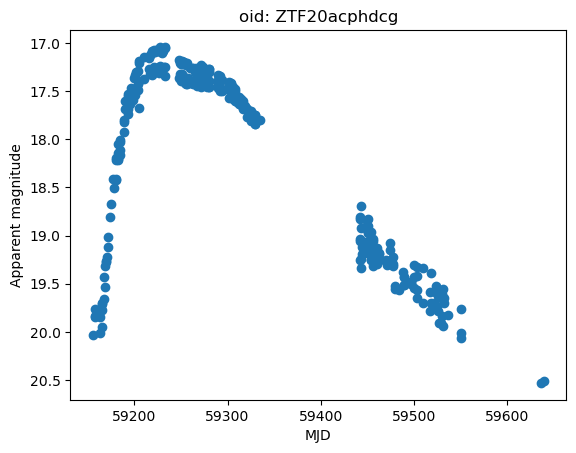

In [14]:
plot_light_curve(one_light_curve, one_light_curve.oid.unique()[0])

# Synthetic Model

The next Syntethic model is based on the papers of [Olivares et al. 2010](https://ui.adsabs.harvard.edu/abs/2010ApJ...715..833O/abstract).

This synthetic model created light-curves based on the next functions:

$$ f_{\text{DF}} = \frac{-a_0}{1+\exp\left( (t - t_{\text{PT}})\right) / w_0}$$
$$ l(t) = p_o(t-t_{\text{PT}}) + m_0$$
$$ g(t) = -P e^{\left(\frac{t-Q}{R}\right)^{2}}

In [15]:
class SyntheticLigthCurve:
    def __init__(self,tpt,a0,w0,p0,m0,P,Q,R):
        self.a0 = a0
        self.w0 = w0
        self.tpt = tpt
        self.p0 = p0
        self.m0 = m0
        self.P = P
        self.Q = Q
        self.R = R

    def olivares(self,t):
        f_fd = -self.a0/(1+np.exp((t-self.tpt)/self.w0))
        f_ld = self.p0*(t-self.tpt)+self.m0
        f_gs =  -self.P * np.exp(-((t-self.Q)/self.R)**2)
        f = f_fd + f_ld + f_gs
        return f

In [16]:
# Definir los parámetros iniciales
p0_v = [91.026,1.744,3.602,0.008,14.482,1.675,102.148,-15.984] # tpt, a0, w0, p0_v, m0, P, Q, R
p0_r = [88.948,1.584,4.485,0.005,13.759,1.528,101.390,-17.934] # tpt, a0, w0, p0_v, m0, P, Q, R
increase_factor = [1, 1, 0.01, 0, 0.01, 0.01, 0.01, 0.01]

N = 1000
time_length = 300 # days

oid = []
mjd = []
mag_v = []
mag_r = []

# Generación de los datos sintéticos
for n in range(N):
    increase_random = np.random.random()
    time = np.linspace(50, 150, 50)
    
    po_v = [p0_v[i] + increase_factor[i] * increase_random for i in range(len(p0_v))]
    po_r = [p0_r[i] + increase_factor[i] * increase_random for i in range(len(p0_r))]
    
    synthetic_lc_v = SyntheticLigthCurve(po_v[0], po_v[1], po_v[2], po_v[3], po_v[4], po_v[5], po_v[6], po_v[7])
    synthetic_lc_r = SyntheticLigthCurve(po_r[0], po_r[1], po_r[2], po_r[3], po_r[4], po_r[5], po_r[6], po_r[7])
    
    f_v = synthetic_lc_v.olivares(time)
    f_r = synthetic_lc_r.olivares(time)
    
    mjd.append(np.array(time))
    mag_v.append(np.array(f_v))
    mag_r.append(np.array(f_r))

# Crear una lista vacía para almacenar los datos
train_data_synthetic = []
test_data_synthetic  = []

# Iterar sobre cada conjunto de tiempo y brillo
for i in range(len(mjd)):
    time_set = mjd[i]
    brightness_set_v = mag_v[i]
    brightness_set_r = mag_r[i]
    code = 'ZTF' + str(i + 1)  # Código de pertenencia (del 1 al N)
    
    for time, brightness_v, brightness_r in zip(time_set, brightness_set_v, brightness_set_r):
        if i + 1 <= int(N * 0.8):  # 80% para entrenamiento
            # Añadir observaciones de filtro v (fid = 1)
            train_data_synthetic.append([code, time, brightness_v, 1])
            # Añadir observaciones de filtro r (fid = 2)
            train_data_synthetic.append([code, time, brightness_r, 2])
        else:  # 20% para prueba
            # Añadir observaciones de filtro v (fid = 1)
            test_data_synthetic.append([code, time, brightness_v, 1])
            # Añadir observaciones de filtro r (fid = 2)
            test_data_synthetic.append([code, time, brightness_r, 2])

# Crear los DataFrames
train_data_synthetic = pd.DataFrame(train_data_synthetic, columns=['oid', 'mjd', 'magpsf', 'fid'])
test_data_synthetic = pd.DataFrame(test_data_synthetic, columns=['oid', 'mjd', 'magpsf', 'fid'])

# Añadir una columna para 'sigmapsf'
train_data_synthetic['sigmapsf'] = 0.001
test_data_synthetic['sigmapsf'] = 0.001

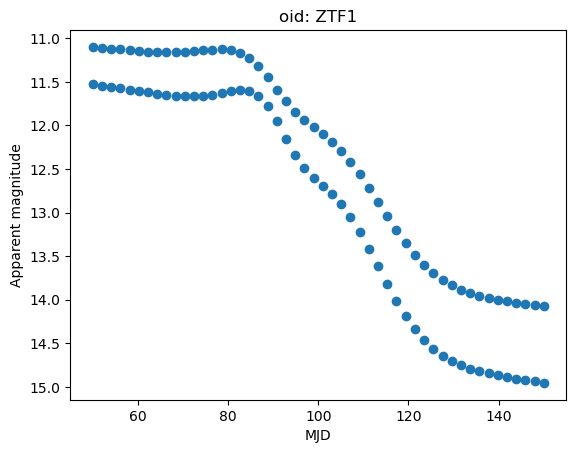

In [17]:
oid_idx = 0
plot_light_curve(train_data_synthetic[train_data_synthetic.oid == train_data_synthetic.oid.unique()[oid_idx]], oid=train_data_synthetic.oid.unique()[oid_idx])

In [18]:
train_data_synthetic = mag_to_flux(train_data_synthetic)
test_data_synthetic  = mag_to_flux(test_data_synthetic)

In [19]:
train_data_synthetic.head()

,oid,mjd,fid,flux,fluxerr
0,ZTF1,50.000000,1,8.902192e-25,3.627438e-20
1,ZTF1,50.000000,2,1.319067e-24,3.627438e-20
2,ZTF1,52.040816,1,8.769586e-25,3.627438e-20
3,ZTF1,52.040816,2,1.306932e-24,3.627438e-20
4,ZTF1,54.081633,1,8.639298e-25,3.627438e-20


In [20]:
train_data = mag_to_flux(train_data)
test_data = mag_to_flux(test_data)

In [21]:
train_data.head()

,oid,mjd,fid,flux,fluxerr
0,ZTF19abgpgyp,59269.523877,2,2.545142e-28,2.987744e-20
1,ZTF19abgpgyp,59253.511354,2,1.943748e-28,2.860300e-20
2,ZTF19abgpgyp,59256.430266,2,1.990673e-28,2.832472e-20
3,ZTF19abgpgyp,59264.536181,2,1.970425e-28,2.754424e-20
4,ZTF19aatubsj,59269.535255,2,2.881244e-28,3.127780e-20


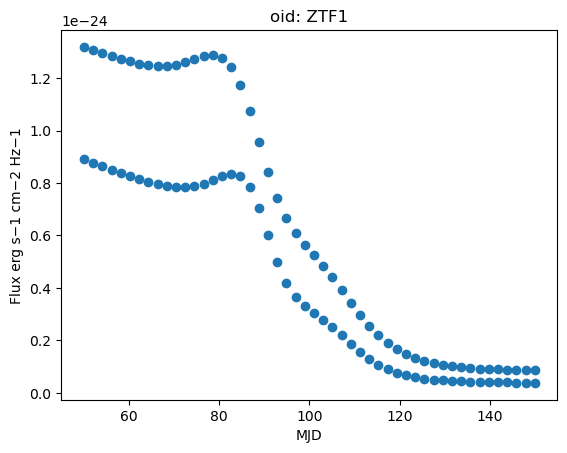

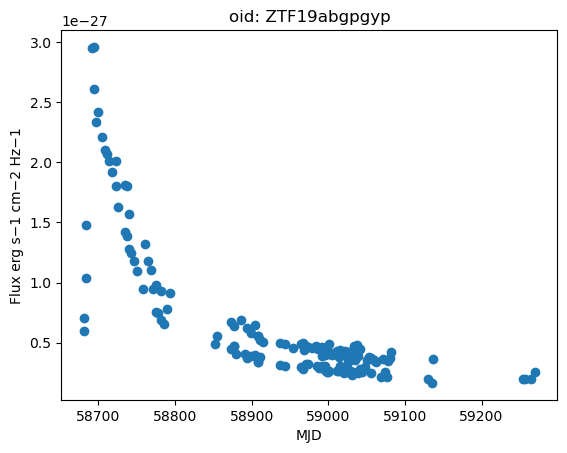

In [22]:
oid_idx = 0
plot_light_curve(train_data_synthetic[train_data_synthetic.oid == train_data_synthetic.oid.unique()[oid_idx]], oid=train_data_synthetic.oid.unique()[oid_idx])
plot_light_curve(train_data[train_data.oid == train_data.oid.unique()[oid_idx]], oid=train_data.oid.unique()[oid_idx])

In [23]:
print(train_data_synthetic.head())
print('\nShape train_data_synthethic:', train_data_synthetic.shape)
print('Length train_data_synthethic:', len(train_data_synthetic))
print()
print(test_data_synthetic.head())
print('\nShape test_data_synthethic:', test_data_synthetic.shape)
print('Length test_data_synthethic:', len(test_data_synthetic))

    oid        mjd  fid          flux       fluxerr
0  ZTF1  50.000000    1  8.902192e-25  3.627438e-20
1  ZTF1  50.000000    2  1.319067e-24  3.627438e-20
2  ZTF1  52.040816    1  8.769586e-25  3.627438e-20
3  ZTF1  52.040816    2  1.306932e-24  3.627438e-20
4  ZTF1  54.081633    1  8.639298e-25  3.627438e-20

Shape train_data_synthethic: (80000, 5)
Length train_data_synthethic: 80000

      oid        mjd  fid          flux       fluxerr
0  ZTF801  50.000000    1  4.874237e-25  3.627438e-20
1  ZTF801  50.000000    2  7.235767e-25  3.627438e-20
2  ZTF801  52.040816    1  4.801642e-25  3.627438e-20
3  ZTF801  52.040816    2  7.169419e-25  3.627438e-20
4  ZTF801  54.081633    1  4.730323e-25  3.627438e-20

Shape test_data_synthethic: (20000, 5)
Length test_data_synthethic: 20000


# Processing the Data

In [24]:
def new_light_curves(light_curves):
    """ Create a new data set adding the grid_time and
    time_index columns
    """

    new_light_curves = pd.DataFrame()
    for id_group, group in light_curves.groupby('oid'):
        light_curve_processed = process_light_curve_parsnip(group)
        new_light_curves = pd.concat([new_light_curves, light_curve_processed])

    return new_light_curves


train_data_synthetic = new_light_curves(train_data_synthetic)
test_data_synthetic  = new_light_curves(test_data_synthetic)

In [25]:
train_data = new_light_curves(train_data)
test_data  = new_light_curves(test_data)

In [26]:
print(train_data_synthetic.head())
print('\nShape train_data_synthethic:', train_data_synthetic.shape)
print('Length train_data_synthethic:', len(train_data_synthetic))
print()
print(test_data_synthetic.head())
print('\nShape test_data_synthethic:', test_data_synthetic.shape)
print('Length test_data_synthethic:', len(test_data_synthetic))

    oid        mjd  fid          flux       fluxerr  grid_time  time_index
0  ZTF1  50.000000    1  8.902192e-25  3.627438e-20  -4.124136         146
1  ZTF1  50.000000    2  1.319067e-24  3.627438e-20  -4.124136         146
2  ZTF1  52.040816    1  8.769586e-25  3.627438e-20  -2.077733         148
3  ZTF1  52.040816    2  1.306932e-24  3.627438e-20  -2.077733         148
4  ZTF1  54.081633    1  8.639298e-25  3.627438e-20  -0.031329         150

Shape train_data_synthethic: (80000, 7)
Length train_data_synthethic: 80000

           oid        mjd  fid          flux       fluxerr  grid_time  \
19900  ZTF1000  50.000000    1  7.067790e-25  3.627438e-20  -4.124136   
19901  ZTF1000  50.000000    2  1.048002e-24  3.627438e-20  -4.124136   
19902  ZTF1000  52.040816    1  6.962514e-25  3.627438e-20  -2.077733   
19903  ZTF1000  52.040816    2  1.038371e-24  3.627438e-20  -2.077733   
19904  ZTF1000  54.081633    1  6.859082e-25  3.627438e-20  -0.031329   

       time_index  
19900        

In [42]:
class LightCurveDataset():
    def __init__(self, dataframe):
        self.dataframe = dataframe
        # Agrupar por 'oid' y almacenar los grupos
        self.groups = dataframe.groupby('oid')

    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        # Obtener el 'oid' por índice (esto devuelve una tupla: (oid, dataframe))
        oid, group = list(self.groups)[idx]

        # Convertir las columnas 'tiempo' y 'mag' en listas
        #mjd = torch.tensor(group['mjd'].values, dtype=torch.float32).to(device)
        #magpsf = torch.tensor(group['magpsf'].values, dtype=torch.float32).to(device)
        #sigmapsf = torch.tensor(group['sigmapsf'].values, dtype=torch.float32).to(device)
        #grid_time = torch.tensor(group['grid_time'].values, dtype=torch.float32).to(device)
        #time_index = torch.tensor(group['time_index'].values, dtype=torch.float32).to(device)

        mjd = group['mjd'].to_numpy()
        flux = group['flux'].to_numpy()
        fluxerr = group['fluxerr'].to_numpy()
        fid = group['fid'].to_numpy()
        grid_time = group['grid_time'].to_numpy()
        time_index = group['time_index'].to_numpy()


        # Retornar un diccionario en el formato deseado
        # light_curve_dict = {
        #     oid: {
        #         'mjd': mjd,
        #         'flux': flux,
        #         'fluxerr': fluxerr,
        #         'grid_time': grid_time,
        #         'time_index': time_index
        #     }
        # }

        light_curve_dict = {
          'mjd': mjd,
          'fid': fid,
          'flux': flux,
          'fluxerr': fluxerr,
          'grid_time': grid_time,
          'time_index': time_index
        }

        # light_curve_dict = {
        #   'mjd': torch.tensor(mjd, dtype=torch.float32).to(device),
        #   'flux': torch.tensor(flux, dtype=torch.float32).to(device),
        #   'fluxerr': torch.tensor(fluxerr, dtype=torch.float32).to(device),
        #   'grid_time': torch.tensor(grid_time, dtype=torch.torch.uint32).to(device),
        #   'time_index': torch.tensor(time_index, dtype=torch.torch.uint32).to(device)
        # }

        return light_curve_dict

# Instancia el dataset personalizado
train_pandas_dataset = LightCurveDataset(train_data)
train_pandas_dataset_synthetic = LightCurveDataset(train_data_synthetic)
test_pandas_dataset = LightCurveDataset(test_data)
test_pandas_dataset_synthetic = LightCurveDataset(test_data_synthetic)

# Crear el DataLoader
train_loader = DataLoader(train_pandas_dataset, batch_size=64, collate_fn=list, shuffle=True)
test_loader = DataLoader(test_pandas_dataset, batch_size=64, collate_fn=list, shuffle=True)

In [ ]:
for batch in train_loader:
    print(type(batch))  # Verifica el tipo de batch
    print(batch[0]['time_index'])
    print(_get_data(batch))
    break

In [31]:
class ModelV0(nn.Module):

    def __init__(self, input_size, hidden_dim, latent_size, device):

        self.device = device
        super().__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=latent_size),
            nn.ReLU()
            )

        # latent mean and variance
        # Acá tenia un dos en
        #mu_size, logvar_size = 3, 3
        self.encode_mean_layer = nn.Linear(in_features=latent_size, out_features=2)
        self.encode_logvar_layer = nn.Linear(in_features=latent_size, out_features=2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=2, out_features=latent_size),
            nn.ReLU(),
            nn.Linear(in_features=latent_size, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=input_size),
            )

        self.to(self.device)

    def encode(self, x):
        print('Shape pre-encoder', x.shape)
        x = x.permute(0,2,1)
        print('second Shape pre-encoder', x.shape)
        x = self.encoder(x)

        print('Entro al Encoder')
        print(x.shape)
        mean, logvar = self.encode_mean_layer(x), self.encode_logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        print('Esta parametrizando al Encoder')
        # Var(x) = std**2 -> 0.5*ln(Var(x)) = ln(std)
        # std = exp(0.5*ln(Var(x)))
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mean + eps*std
        return z

    def decode(self, x):
        print('Entro al DeEncoder')
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        print('Melo el forward')
        return x_hat, mean, logvar

    def obtain_results(self, light_curves):

        data = _get_data(light_curves)
        print('Paso el Get data')

        # Encode the light_curves
        encoding_mu, encoding_logvar = self.encode(data['input_data'])
        #print(encoding_mu)
        #print(encoding_logvar)

        time = data['compare_data'][:,0]
        obs_flux = data['compare_data'][:, 1]
        obs_fluxerr = data['compare_data'][:, 2]
        obs_weight = data['compare_data'][:, 3]

        results ={
            'redshift': data['redshift'],
            'time': time,
            'obs_flux': obs_flux,
            'obs_fluxerr': obs_fluxerr,
            'obs_weight': obs_weight,
            'encoding_mu': encoding_mu,
            'encoding_logvar': encoding_logvar,
        }

        #results = {k:v.detach().cpu().numpy() for k,v in results.items()}
        #results = {k:v.detach().cpu().numpy() for k,v in results.items()}

        return results

In [43]:
class ModelV1(nn.Module):
    """ This model will use Conv1d to encode the NN
    The Output Size using Conv1d in Pytorch could be calculated using:

    L_out = [Lin + 2 x padding - dilation x (kernel_size - 1) - 1] / stride + 1

    Also this modle will use ConvTransposed1d to decode the NN
    The Ouput size using ConvTransposed1d in PyTorch could be calculated using:

    L_out=(Lin-1)xstride-2xpadding+dilationx(kernel_size-1)+output_padding+1

    """

    def __init__(self, input_size: int, latent_size: int, batch_size:int, device: str, **kwargs) -> None:
        super().__init__()
        self.device = device

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=16, kernel_size=3, dilation=1, padding=2*1),  # Input size [batch_size, input_size = 3, 300] Output_size = [batch_size, 16, 302]
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, dilation=1, padding=2*1),  # Input size [batch_size, input_size = 16, 302] Output_size = [batch_size, 32, 304]
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, dilation=1, padding=2*1), # Input size [batch_size, input_size = 32, 304] Output_size = [batch_size, 64, 306]
            nn.ReLU(inplace=True),
            )

        self.linear = nn.Linear(in_features=batch_size*306, out_features=64)

        # Linear layers for encoding mean and logvar
        self.encode_mean = nn.Linear(in_features=64, out_features=latent_size)
        self.encode_logvar = nn.Linear(in_features=64, out_features=latent_size)

        # Decoder input layer
        self.decoder_input = nn.Linear(in_features=latent_size, out_features=64)

        # Decoder with transposed convolutions (ConvTranspose1d)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=3, padding=2*1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=3, padding=2*1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=3, kernel_size=3, padding=2*1)  # Output size [batch_size, 3, input_size]
        )

        self.to(self.device)

    def encode(self, x):
        print('Shape pre-encoder', x.shape)
        x = self.encoder(x)
        print('Shape Encoder:',x.shape)
        x = x.view(64, -1) # Flatten the output, keeping batch dimension
        #print('Shape after flattening:', x.shape)
        x = self.linear(x)
        mu, log_var = self.encode_mean(x), self.encode_logvar(x)
        print('Shape mu:',mu.shape)
        print('Shape log_var:',log_var.shape)
        return mu, log_var

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        result = self.decoder_input(z)
        result = self.decoder(result)
        return result

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, input: torch.Tensor, **kwargs) -> list:
        print('Shape input:',input.shape)
        mu, log_var = self.encode(input)
        print('Shape mu:',mu.shape)
        print('Shape log_var:',log_var.shape)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), input, mu, log_var]

    def obtain_results(self, light_curves):

        data = _get_data(light_curves)
        print('Paso el Get data')

        # Encode the light_curves
        encoding_mu, encoding_logvar = self.encode(data['input_data'])
        #print(encoding_mu)
        #print(encoding_logvar)

        time = data['compare_data'][:,0]
        obs_flux = data['compare_data'][:, 1]
        obs_fluxerr = data['compare_data'][:, 2]
        obs_weight = data['compare_data'][:, 3]

        results ={
            'redshift': data['redshift'],
            'time': time,
            'obs_flux': obs_flux,
            'obs_fluxerr': obs_fluxerr,
            'obs_weight': obs_weight,
            'fid': data['fid'],
            'encoding_mu': encoding_mu,
            'encoding_logvar': encoding_logvar,
        }

        #results = {k:v.detach().cpu().numpy() for k,v in results.items()}
        #results = {k:v.detach().cpu().numpy() for k,v in results.items()}

        return results

In [44]:
input_size = 5 # input_size = 2 * N_bands + 1 -> 2: flux and error 1 for redshift.
h_dim = 200
z_dim = 20
num_epoch = 1
batch_size = 32
learning_rate = 1e-4

#model = ModelV0(input_size=input_size, hidden_dim=h_dim, latent_size=z_dim, device=device)
model = ModelV1(input_size = input_size, latent_size = z_dim, batch_size=batch_size, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_loader = DataLoader(train_pandas_dataset, batch_size=batch_size, collate_fn=list, shuffle=True)
train_loader_synthetic = DataLoader(train_pandas_dataset_synthetic, batch_size=batch_size, collate_fn=list, shuffle=False)

test_loader = DataLoader(test_pandas_dataset, batch_size=batch_size, collate_fn=list, shuffle=True)
test_loader_synthetic = DataLoader(test_pandas_dataset_synthetic, batch_size=batch_size, collate_fn=list, shuffle=False)

#train_loader = DataLoader(train_pandas_dataset, batch_size=batch_size, collate_fn=list, shuffle=True)
#test_loader = DataLoader(test_pandas_dataset, batch_size=batch_size, collate_fn=list, shuffle=True)

In [45]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
ModelV1                                  --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       256
│    └─ReLU: 2-2                         --
│    └─Conv1d: 2-3                       1,568
│    └─ReLU: 2-4                         --
│    └─Conv1d: 2-5                       6,208
│    └─ReLU: 2-6                         --
├─Linear: 1-2                            626,752
├─Linear: 1-3                            1,300
├─Linear: 1-4                            1,300
├─Linear: 1-5                            1,344
├─Sequential: 1-6                        --
│    └─ConvTranspose1d: 2-7              6,176
│    └─ReLU: 2-8                         --
│    └─ConvTranspose1d: 2-9              1,552
│    └─ReLU: 2-10                        --
│    └─ConvTranspose1d: 2-11             147
Total params: 646,603
Trainable params: 646,603
Non-trainable params: 0

In [46]:
def loss_function(results):

#     print('X_reconstructed:\nType:',type(X_reconstructed),\
#           '\nShape:',X_reconstructed.shape)
#     print('X_weights:\nType',type(X_weights),\
#           '\nShape:',X_weights.shape)
      nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
      kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
                      - torch.tensor(results['encoding_mu'], requires_grad=True)**2
                      - torch.exp(torch.tensor(results['encoding_logvar'], requires_grad=True)))

      nll = torch.sum(nll)
      #print(nll)
      kl_div = torch.sum(kld)
      #print(kl_div)

      return nll + kl_div

In [47]:
def replace_nan_grads(parameters, value=0.0):
    """Replace NaN gradients

    Parameters
    ----------
    parameters : Iterator[torch.Tensor]
        Model parameters, usually you can get them by `model.parameters()`
    value : float, optional
        Value to replace NaNs with
    """
    for p in parameters:
        if p.grad is None:
            continue
        grads = p.grad.data
        grads[torch.isnan(grads)] = value

In [65]:
train_losses = []
for epoch in tqdm(range(num_epoch)):
    # Set the model to training mode
    model.train()
    i = 0
    train_loss = 0.0

    # Iteration over the batches
    #for i, batch in enumerate(train_loader_synthetic):
    for i, batch in enumerate(train_loader):
        print(i)
        results = model.obtain_results(batch)
        loss = loss_function(results)

        loss.backward()
        train_loss += loss.item()
        train_losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad()

    # Puedes añadir un mensaje de final de epoch aquí si lo deseas
    #if epoch % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {train_loss / len(batch)}')

  0%|          | 0/1 [00:00<?, ?it/s]

0
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

1
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

2
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

3
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

4
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

5
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

6
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

7
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

8
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

9
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

10
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

11
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

12
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

13
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

14
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

15
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

16
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

17
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

18
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

19
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

20
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

21
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

22
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

23
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

24
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

25
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

26
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

27
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

28
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

29
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

30
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

31
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

32
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

33
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

34
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

35
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

36
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

37
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

38
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

39
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

40
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

41
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

42
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

43
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

44
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

45
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

46
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

47
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

48
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

49
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

50
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

51
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

52
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

53
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

54
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

55
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

56
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

57
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

58
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

59
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

60
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

61
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

62
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

63
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

64
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

65
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

66
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

67
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

68
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

69
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

70
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

71
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

72
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

73
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

74
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

75
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

76
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

77
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

78
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

79
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

80
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

81
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

82
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

83
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

84
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

85
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

86
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

87
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

88
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

89
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

90
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

91
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

92
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

93
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

94
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

95
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

96
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

97
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

98
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

99
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

100
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

101
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

102
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

103
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

104
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

105
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

106
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

107
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

108
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

109
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

110
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

111
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

112
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

113
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

114
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

115
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

116
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

117
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

118
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

119
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

120
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

121
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

122
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

123
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

124
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

125
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

126
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

127
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

128
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

129
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

130
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

131
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

132
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

133
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

134
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

135
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

136
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

137
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

138
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

139
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

140
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

141
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

142
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

143
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

144
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

145
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

146
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

147
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

148
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

149
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

150
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

151
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

152
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

153
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

154
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

155
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

156
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

157
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

158
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

159
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

160
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

161
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

162
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

163
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

164
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

165
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

166
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

167
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

168
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

169
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

170
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

171
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

172
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

173
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

174
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

175
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

176
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

177
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

178
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

179
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

180
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

181
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

182
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

183
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

184
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

185
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

186
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

187
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

188
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

189
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

190
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

191
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

192
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

193
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

194
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

195
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

196
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

197
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

198
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

199
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

200
Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

201
Comenzo get_data
Grid shape: (1, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([1, 5, 300])
Shape Encoder: torch.Size([1, 64, 306])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x306 and 9792x64)

In [66]:
predictions = []
model.eval()
with torch.inference_mode():
    test_loss = 0.0
    for batch in test_loader:
        results = model.obtain_results(batch)
        predictions.append(results)
        loss = loss_function(results)

        test_loss += loss.item()

    print(f'Test Loss: {test_loss / len(batch)}')

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (32, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([32, 5, 300])
Shape Encoder: torch.Size([32, 64, 306])
Shape mu: torch.Size([64, 20])
Shape log_var: torch.Size([64, 20])


/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
Grid shape: (9, 2, 300)
Paso el Get data
Shape pre-encoder torch.Size([9, 5, 300])
Shape Encoder: torch.Size([9, 64, 306])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x2754 and 9792x64)

In [49]:
predictions = []
model.eval()
with torch.inference_mode():
    test_loss = 0.0
    for batch in test_loader_synthetic:
        results = model.obtain_results(batch)
        predictions.append(results)
        loss = loss_function(results)

        test_loss += loss.item()

    print(f'Test Loss: {test_loss / len(batch)}')

Comenzo get_data
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, d

/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, d

/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, d

/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, d

/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, d

/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

Comenzo get_data
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, d

/tmp/ipykernel_5342/3808935312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = (0.5 * torch.tensor(results['obs_weight']) * torch.tensor(results['obs_flux'])**2)
/tmp/ipykernel_5342/3808935312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kld = -0.5 * (1 + torch.tensor(results['encoding_logvar'], requires_grad=True)
/tmp/ipykernel_5342/3808935312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - torch.tensor(results['encoding_mu'], requires_grad=True)**2
/tmp/ipykernel_5342/3808935312.py:10: UserWarning: To copy constr

fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo el grid
fid:
 0     1
1     2
2     1
3     2
4     1
     ..
95    2
96    1
97    2
98    1
99    2
Name: fid, Length: 100, dtype: int64
Creo 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x2448 and 9792x64)

In [50]:
predictions[0].keys()

dict_keys(['redshift', 'time', 'obs_flux', 'obs_fluxerr', 'obs_weight', 'fid', 'encoding_mu', 'encoding_logvar'])

In [51]:
print(predictions[0]['obs_flux'])
print('Predictions 0 shape obs_flux:', predictions[0]['obs_flux'].shape)
print(predictions[0]['time'])
print('Predictions 0 shape obs_flux:', predictions[0]['time'].shape)

tensor([[7.0678e-25, 1.0480e-24, 6.9625e-25,  ..., 8.6663e-26, 3.7850e-26,
         8.5787e-26],
        [4.8742e-25, 7.2358e-25, 4.8016e-25,  ..., 8.6824e-26, 3.7878e-26,
         8.5947e-26],
        [5.2029e-25, 7.7220e-25, 5.1254e-25,  ..., 8.6796e-26, 3.7873e-26,
         8.5919e-26],
        ...,
        [5.0331e-25, 7.4709e-25, 4.9581e-25,  ..., 8.6810e-26, 3.7875e-26,
         8.5933e-26],
        [7.0963e-25, 1.0522e-24, 6.9906e-25,  ..., 8.6661e-26, 3.7849e-26,
         8.5786e-26],
        [6.1455e-25, 9.1164e-25, 6.0539e-25,  ..., 8.6723e-26, 3.7860e-26,
         8.5847e-26]])
Predictions 0 shape obs_flux: torch.Size([32, 100])
tensor([[ -4.1241,  -4.1241,  -2.0777,  ...,  94.1032,  96.1497,  96.1497],
        [-29.1241, -29.1241, -27.0777,  ...,  69.1032,  71.1497,  71.1497],
        [-29.1241, -29.1241, -27.0777,  ...,  69.1032,  71.1497,  71.1497],
        ...,
        [-29.1241, -29.1241, -27.0777,  ...,  69.1032,  71.1497,  71.1497],
        [ -4.1241,  -4.1241,  -2.07

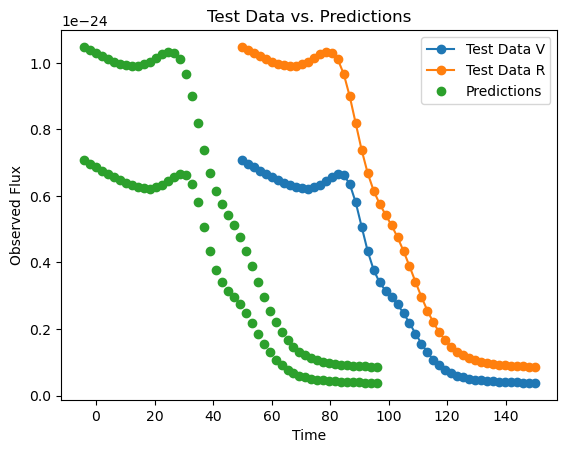

In [52]:
# Assuming 'predictions' contains the output from your model for the test set

for i, batch in enumerate(test_loader_synthetic):
  if i == 0:
    # Access the data in the batch (assuming it's in the format [data, labels])
    data = batch[0]
    data = pd.DataFrame(data)
    data_v = data[data['fid'] == 1]
    data_r = data[data['fid'] == 2]
    # Assuming your data has 'time' and 'obs_flux' attributes
    time_v = data_v['mjd']
    time_r = data_r['mjd']
    obs_flux_r = data_r['flux']
    obs_flux_v = data_v['flux']

    # Plot the data from the test loader
    plt.plot(time_v, obs_flux_v, '-o', label='Test Data V')
    plt.plot(time_r, obs_flux_r, '-o', label='Test Data R')

# Plot the predictions
plt.plot(predictions[0]['time'][0], predictions[0]['obs_flux'][0], 'o', label='Predictions')

plt.xlabel('Time')
plt.ylabel('Observed Flux')
plt.title('Test Data vs. Predictions')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(num_epoch), np.array(train_losses)/300)
ax.set_xlabel('Epochs')
ax.set_ylabel('Train loss')

In [ ]:
def plot_curves(time, original_magnitude, reconstructed_magnitude, title='Curvas Originales y Reconstruidas'):
    plt.figure(figsize=(12, 6))
    plt.plot(time, original_magnitude, label='Original', linestyle='--', color='blue')
    plt.plot(time, reconstructed_magnitude, label='Reconstruido', linestyle='-', color='red')
    plt.xlabel('Tiempo')
    plt.ylabel('Magnitud')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
model.eval()

# Definir una lista para almacenar las pérdidas de cada muestra de prueba
test_losses = []

# Definir una lista para almacenar las reconstrucciones de las muestras de prueba
reconstructions = []

#with torch.inference_mode():
with torch.inference_mode():
    for _, group_oid in test_data_synthetic.groupby(by='oid'):
        X = group_oid[['mjd','magpsf','sigmapsf']]
        #X = process_light_curve_atat(X)# Karpathy constant is just a joke
        X = process_light_curve_parsnip(X)
        X, X_weights = create_grid(X)
        time = X[0,:]
        original_magnitude = X[1,:]
        X = torch.tensor(X, dtype=torch.float32)
        X_weights = torch.tensor(X_weights, dtype=torch.float32)
        X = X.T
        X_weights = X_weights.T

        # Forward pass
        X_reconstructed, mu, logvar = model(X)

        #print(X_reconstructed)
        # Convierte las predicciones a numpy
        reconstructed_magnitude = X_reconstructed.cpu().numpy()[:,0]  # Segunda fila para magnitud
        #print(len(reconstructed_magnitude))
        
        # Grafica
        plot_curves(time, original_magnitude, reconstructed_magnitude, title=f'Curvas para OID {oid}')
        
        # Sal de la iteración si solo deseas graficar para un OID
        break

        # Compute loss
        loss = loss_function(X_reconstructed, X_weights, mu, logvar)
        #replace_nan_grads(model.parameters())

        # Guardar la pérdida y las reconstrucciones
        test_losses.append(loss.item())
        reconstructions.append(X_reconstructed.cpu().numpy())

    # Calcular la pérdida promedio en los datos de prueba
    average_test_loss = np.mean(test_losses)
    print("Average test loss:", average_test_loss)

In [ ]:
reconstructions = np.array(reconstructions)
len(reconstructions[0][:,0]), len(reconstructions[0][:,1])

In [ ]:
reconstructions[0][:,0]

In [ ]:
sample_index = 2
sample_data = test_data_synthetic[test_data_synthetic.oid == test_data_synthetic.oid.unique()[sample_index]]
sample_data = process_light_curve_parsnip(sample_data)
sample_data, _ = create_grid(sample_data)
sample_reconstruction = reconstructions[sample_index]

fig, ax = plt.subplots()

ax.plot(sample_data[0,:], sample_data[1,:], 'o', color='C0')
ax.plot(np.linspace(0,300,300), sample_reconstruction[:,1], 'o', color='C1')

ax.set_xlabel('Time')
ax.set_ylabel('Flux')
ax.set_title('Original vs. Reconstructed Flux')
#ax.legend()
#ax.invert_yaxis()
plt.show()